In [26]:
%run ../robustness_analysis.ipynb

In [2]:
from lunarlander import *

In [3]:
# define variables and their bounds
wind_power = [0.0, 20.0]
turbulence_power = [0.0, 2.0]

# define the range of the deviation parameters
dev_bounds = np.asarray([wind_power, turbulence_power])

# define the range of initial force apply to the lander
x0_bounds = np.repeat([[-INITIAL_RANDOM, INITIAL_RANDOM]], 2, axis=0)

# define the deviation parameter value for the original environment (no deviation)
delta_0 = np.asarray([0.0, 0.0])

In [4]:
def env_builder(delta):
    return LunarLander(enable_wind=True, continuous=True, wind_power=delta[0], turbulence_power=delta[1]), x0_bounds

In [5]:
from scipy import linalg

def lqr(s):
    # gravity = 9.8/FPS/FPS/SCALE
    gravity = 9.8 / FPS / FPS # gravity changes depending on SCALE
    m_main_inv = gravity / 0.56    # determined by test
    m_side_inv = gravity * 0.365    # determined by test
    a_sina_i_inv= 0.198 / 100 # determined by test # not depending on SCALE
    cos_alpha = 0.72

    # target point set
    x_target = 0
    y_target = 0   # the landing point is 0
    Vx_target = 0
    Vy_target = 0
    theta_target = 0
    omega_target = 0

    """
    Design of the reference trajectory
    """
    y_target = s[1] * (VIEWPORT_H / SCALE / 2) / 1.6 # 1.6 succeeds all the times

    """
    Design of a state space representation
    """
    X = np.array([
        [s[0] * (VIEWPORT_W / SCALE / 2) - x_target],
        [s[1] * (VIEWPORT_H / SCALE / 2) - y_target],
        [s[2] / (VIEWPORT_W / SCALE / 2) - Vx_target],
        [s[3] / (VIEWPORT_H / SCALE / 2) - Vy_target],
        [s[4] - theta_target],
        [s[5] / 20.0 - omega_target]
    ])

    A = np.array([
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, -1 * gravity, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0]
    ])

    B = np.array([
        [0, 0],
        [0, 0],
        [0, m_side_inv * cos_alpha * cos_alpha],
        [1 * m_main_inv, 0],
        [0, 0],
        [0, -1 * a_sina_i_inv]
    ])
    # the second term of the 4th row of B was igonred for simplification assuming that Fside is smaller than Fmain and negligible while Fmain is used

    sigma = np.array([
        [0],
        [0],
        [0],
        [-1 * gravity],
        [0],
        [0]
    ])

    # gravity compensation
    BTB = np.dot(B.T, B)
    u_sigma = -1 * np.linalg.inv(BTB).dot(B.T).dot(sigma)

    """
    Design of LQR
    Solve Riccati equation to find a optimal control input
    """
    R = np.array([
        [1, 0],
        [0, 1]
    ])

    Q = np.array([
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 100, 0],
        [0, 0, 0, 0, 0, 100]
    ])

    # Solving Riccati equation
    P = linalg.solve_continuous_are(A, B, Q, R)
    # print("P {}\n".format(P))

    # u = -KX
    # K = R-1*Rt*P
    K = np.linalg.inv(R).dot(B.T).dot(P)
    # print("K {}\n".format(K))
    thrust = -1 * np.dot(K, X) + u_sigma
    # thrust = -1*np.dot(K, X)

    """
    Free fall from the final short distance
    """
    if s[1] < 0.3 / SCALE:
        thrust[0] = 0
        thrust[1] = 0

    # conversion to compensate main thruster's tricky thrusting
    thrust[0] = thrust[0] / 0.5 - 1.0

    a = np.array([thrust[0], thrust[1]])
    a = np.clip(a, -1, +1)  #  if the value is less than 0.5, it's ignored
    return a.flatten()

In [6]:
agent = {
    # define the action generation function of the given agent
    'next_action': lambda obs: lqr(obs),

    # some agents (like PID) needs to be reset for each run
    'model_reset': None
}

In [7]:
obs_space = env_builder(delta_0)[0].observation_space
angle_range = np.asarray([obs_space.low[4], obs_space.high[4]])
x_range = np.asarray([obs_space.low[0], obs_space.high[0]])
y_range = np.asarray([obs_space.low[1], obs_space.high[1]])


def stl_prop():    
    # G ( |angle| < 45 && |x| < 0.6|y| + 0.1 )
    angle = stl.Predicate('angle')
    delta_x = stl.Predicate('delta_x')
    
    angle_threshold = normalize(45 * 2 * np.pi / 360, angle_range)
    
    return stl.Always( (angle < angle_threshold) & (delta_x < 0.1) )
    

def signal_builder(records, time_index):    
    return {
        'angle': stl.Signal(
            normalize(np.abs(records[:, 4]), angle_range),
            time_index
        ),
        'delta_x': stl.Signal(
            normalize(np.abs(records[:, 0]), x_range) - normalize(np.abs(0.6 * records[:, 1]), y_range),
            time_index
        )
    }
    

def episode_eval(obs_record, reward_record):
    return compute_stl_rob(stl_prop(), signal_builder, obs_record)

In [8]:
# l-2 norm distance
def dist(delta, delta_0):
    delta = normalize(delta, dev_bounds)
    delta_0 = normalize(delta_0, dev_bounds)
    return np.sqrt(np.sum((delta - delta_0) ** 2))

In [9]:
if not os.path.exists('gifs'):
    os.mkdir('gifs')

In [27]:
analysis = RobustnessAnalysis(env_builder, agent, episode_eval, delta_0, dev_bounds, dist)
analysis.options['steps_of_each_x0'] = 300
analysis.options['deviation_restarts'] = 2
analysis.options['deviation_sigma'] = 0.2
analysis.options['deviation_evals'] = 100
# analysis.options['deviation_timeout'] = 20
analysis.options['falsification_sigma'] = 0.4
analysis.options['falsification_timeout'] = 1
analysis.options['falsification_restarts'] = 1
analysis.options['falsification_episodes'] = 40
analysis.options

{'epsilon': 0.01,
 'deviation_restarts': 2,
 'deviation_sigma': 0.2,
 'deviation_timeout': inf,
 'deviation_evals': 100,
 'falsification_sigma': 0.4,
 'falsification_timeout': 1,
 'falsification_restarts': 1,
 'falsification_episodes': 40,
 'episodes_of_each_x0': 1,
 'steps_of_each_x0': 300}

In [11]:
# start = datetime.now()
# analysis.deviated_sys_eval([5.1, 0.2])
# datetime.now() - start

## Compare the number of evaluations

In [12]:
def run_data(analysis, name, n=10, evals=50, out_dir='data'):
    dists_name = f"{out_dir}/{name}-dists-{n}-{evals}.csv"
    times_name = f"{out_dir}/{name}-times-{n}-{evals}.csv"
    if os.path.exists(dists_name) and os.path.exists(times_name):
        dists = np.loadtxt(dists_name, delimiter=',')
        times = np.loadtxt(times_name, delimiter=',')
    else:
        analysis.options['deviation_evals'] = evals
        dists, times = [], []
        for _ in range(n):
            start = datetime.now()
            result = analysis.min_unsafe_deviation()
            dists.append(result.delta_dist)
            times.append((datetime.now() - start).total_seconds())

        dists, times = np.array(dists), np.array(times)
        np.savetxt(dists_name, dists, delimiter=',')
        np.savetxt(times_name, times, delimiter=',')
    return dists, times

In [13]:
def test_evals(analysis, name, out_dir):
    evals = np.arange(25, 126, 25)
    data = []
    for e in evals:
        dists, _ = run_data(analysis, name, evals=e, out_dir=out_dir)
        data.append(dists)
    # plt.boxplot(data, labels=evals)
    # plt.show()
    return data

### Basic CMA

In [28]:
data1 = test_evals(analysis, 'BasicCMA', 'data')

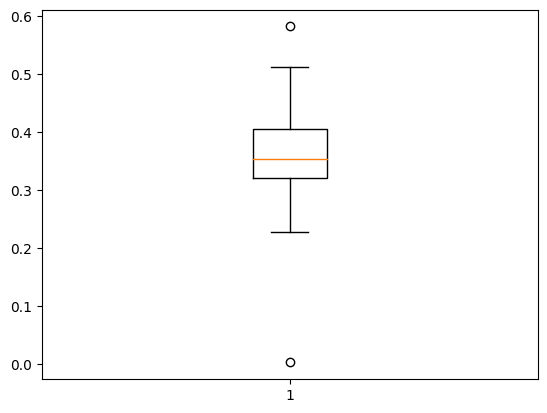

In [29]:
b = plt.boxplot(np.ndarray.flatten(np.asarray(data1)))
boundary = [l.get_ydata()[1] for l in b['whiskers']][0]

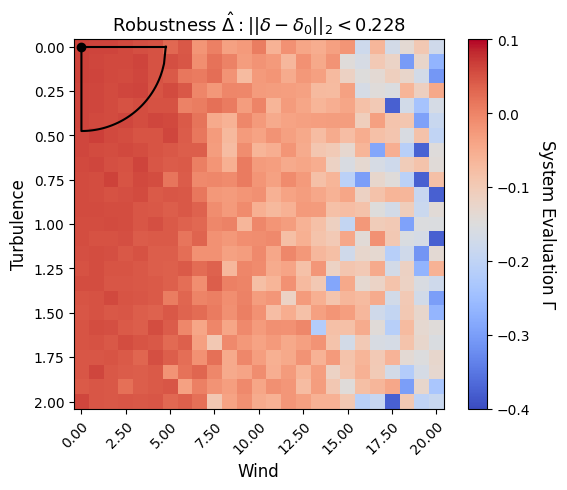

In [30]:
plt.rc('axes', labelsize=12, titlesize=13)
_ = analysis.heatmap(wind_power, turbulence_power, 25, 25, x_name="Wind", y_name="Turbulence", z_name="System Evaluation $\Gamma$",
                     out_dir='data', boundary=boundary, vmax=0.1, vmin=-0.4)
plt.title('Robustness $\hat{\Delta}: ||\delta - \delta_0||_2 < %.3f$' % boundary)
plt.savefig('gifs/robustness-landscape-boundary-heatmap.png', bbox_inches='tight')

### Random sample

In [31]:
data2 = test_evals(RandomMinDev(analysis), 'Random', 'data')

In [32]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

def boxplot(datas, colors, labels, legends):
    num_group = len(datas)
    num_each_group = len(datas[0])
    total = num_group * num_each_group
    for i in range(num_group):
        bp = plt.boxplot(datas[i], positions=np.arange(i+1, total+1, num_group)+np.arange(num_each_group), showfliers=False)
        set_box_color(bp, colors[i])
    
    plt.xticks(np.arange(1+(num_group-1)/2, total, num_group)+np.arange(num_each_group), labels=labels)

    for i in range(num_group):
        plt.plot([], c=colors[i], label=legends[i])
    plt.legend()

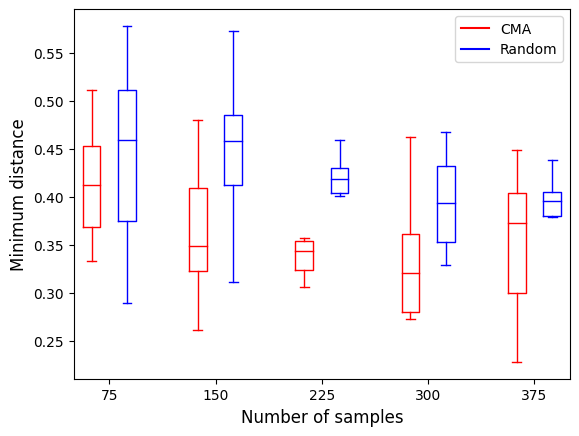

In [33]:
plt.xlabel('Number of samples')
plt.ylabel('Minimum distance')
boxplot([data1, data2], ['red', 'blue'], np.arange(25, 126, 25)*(analysis.options['deviation_restarts']+1),
        ['CMA', 'Random'])
plt.savefig('gifs/sample-boxplot.png', bbox_inches='tight')